In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, time, scipy, h5py
import numpy as np
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from ipywidgets import interact, interact_manual
from scipy.optimize import minimize, approx_fprime
from termcolor import colored, cprint
from scipy.interpolate import RectBivariateSpline

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data, artificial_anneal as anneal
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format='retina'

Could not import BEM module. Please do so manually.


In [35]:
save_path = r"/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Resonator"
sub_dir_1 = r"161123_101536_M018V1_resonator_sweep_150_electrons"
sub_dir_2 = r"161123_110859_M018V1_resonator_sweep_150_electrons"
sub_dir_3 = r"161123_144607_M018V1_resonator_sweep_150_electrons"

def load_data(sub_dir):
    converged = list()
    energy = list()
    with h5py.File(os.path.join(os.path.join(save_path, sub_dir), "Results.h5"), "r") as f:
        k = 0
        for step in f.keys():
            if "step" in step:
                #print(step)
                electron_ri = f[step + "/electron_final_coordinates"][()]
                xi, yi = anneal.r2xy(electron_ri)
                converged.append(f[step + "/solution_converged"][()])
                energy.append(f[step + "/energy"][()])
                k += 1

        Vres = f["Vres"][()]
        
    return Vres, energy

In [36]:
Vres_1, energy_1 = load_data(sub_dir_1)
Vres_2, energy_2 = load_data(sub_dir_2)
Vres_3, energy_3 = load_data(sub_dir_3)

# Adaptive initial condition 
energy_1 = np.array(energy_1)
# Start with same initial condition every time (single row)
energy_2 = np.array(energy_2)
# Start with same initial condition every time (two rows)
energy_3 = np.array(energy_3)

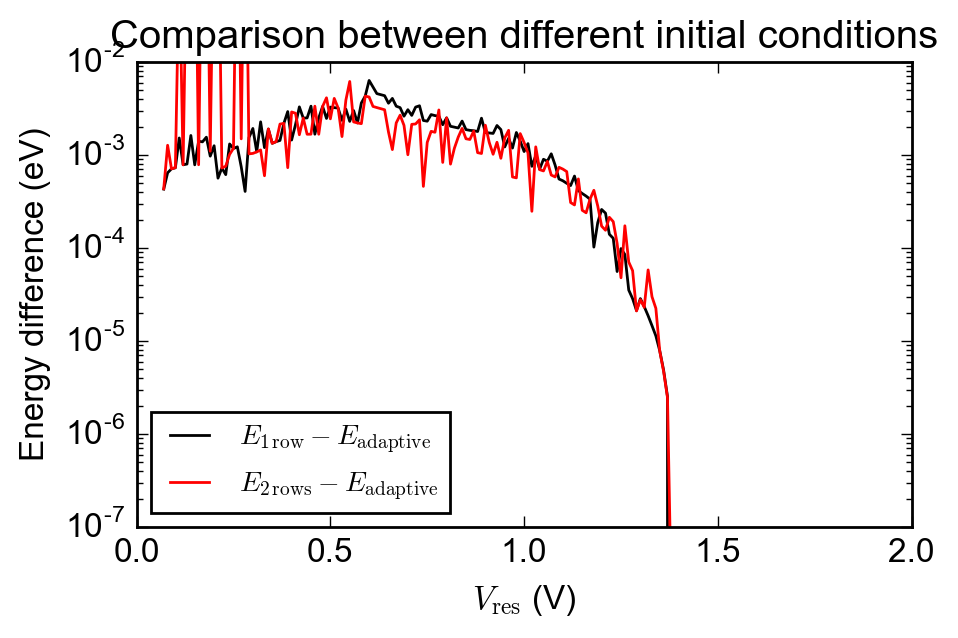

In [44]:
fig = plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(Vres_1, energy_2 - energy_1, '-k', label="$E_\mathrm{1\,row}-E_\mathrm{adaptive}$")
plt.plot(Vres_1, energy_3 - energy_1, '-r', label="$E_\mathrm{2\,rows}-E_\mathrm{adaptive}$")
plt.yscale('log')
plt.ylim(1E-7, 1E-2)
#plt.plot(Vres_2, energy_2, '-r', label="Adaptive initial condition")
plt.xlabel("$V_\mathrm{res}$ (V)")
plt.ylabel("Energy difference (eV)")
plt.title("Comparison between different initial conditions")
plt.legend(loc=3, prop={"size": 10})

for sub_dir in [sub_dir_1, sub_dir_2, sub_dir_3]:
    common.save_figure(fig, save_path=os.path.join(save_path, sub_dir))

The fact that the energy difference is positive means that when you start with the same initial condition for every voltage point, in this case a single row, you end up in a higher energy state. The difference starts to become substantial in the case where the configuration forms two rows and peaks at around 0.6 V. 

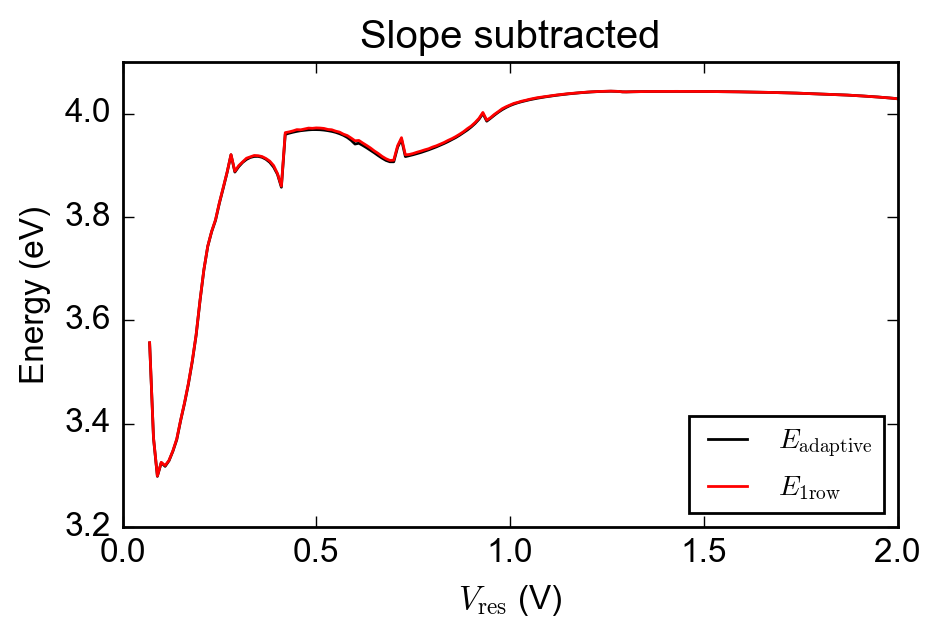

In [34]:
fig = plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(Vres_1, energy_1 + 0.602*150*np.array(Vres_1), '-k', label="$E_\mathrm{adaptive}$")
plt.plot(Vres_2, energy_2 + 0.602*150*np.array(Vres_2), '-r', label="$E_\mathrm{1 row}$")

#plt.plot(Vres_1, energy_3 - energy_1, '-r', label="$E_\mathrm{2 rows}-E_\mathrm{adaptive}$")
#plt.yscale('log')
#plt.ylim(1E-7, 1E-2)
#plt.plot(Vres_2, energy_2, '-r', label="Adaptive initial condition")
plt.xlabel("$V_\mathrm{res}$ (V)")
plt.ylabel("Energy (eV)")
plt.title("Slope subtracted")
plt.legend(loc=4, prop={"size": 10})